# Model Prediction/Evaluation

Finally, we are at the final Chapter where we see the end-product of the model created. As we venture into this critical phase, the model_predict script emerges as a lighthouse, guiding the way toward understanding and anticipating the future of snow water equivalent (SWE) through the RandomForestHole model. This chapter delves into the intricacies of this script, unraveling the processes that transform raw, unprocessed data into precise predictions that illuminate the path forward.

**Preparing for Prediction:**
This begins with loading and pre-processing of data

Loading Data: The script starts by ingesting data from a CSV file, bringing into the fold the vast array of variable

In [1]:
def load_data(file_path):
  """
  Load data from a CSV file.
  Args: file_path (str): Path to the CSV file containing the data.
  Returns: pd.DataFrame: A pandas DataFrame containing the loaded data.
   """
  return pd.read_csv(file_path)

Pre-processing: Next, the data undergoes a transformation. Dates are converted, irrelevant columns are discarded, and the data is reshaped to match the model's expectations. This step is akin to sharpening the sword before battle, ensuring that the model's input is not only precise but also aligned with the temporal and spatial intricacies of snow accumulation and melt.

In [2]:
def preprocess_data(data):
  """
  Preprocess the input data for model prediction.
  Args: data (pd.DataFrame): Input data in the form of a pandas DataFrame.
  Returns: pd.DataFrame: Preprocessed data ready for prediction.
  """
  data['date'] = pd.to_datetime(data['date'])
  data.replace('--', pd.NA, inplace=True)
  data.rename(columns={'Latitude': 'lat', 'Longitude': 'lon',
                       'vpd': 'mean_vapor_pressure_deficit',
                       'vs': 'wind_speed', 'pr': 'precipitation_amount',
                       'etr': 'potential_evapotranspiration', 'tmmn': 'air_temperature_tmmn',
                       'tmmx': 'air_temperature_tmmx', 'rmin': 'relative_humidity_rmin',
                       'rmax': 'relative_humidity_rmax', 'cumulative_AMSR_SWE': 'cumulative_SWE',
                       'cumulative_AMSR_Flag': 'cumulative_Flag', 'cumulative_tmmn':'cumulative_air_temperature_tmmn',
                       'cumulative_etr': 'cumulative_potential_evapotranspiration', 'cumulative_vpd': 'cumulative_mean_vapor_pressure_deficit',
                       'cumulative_rmax': 'cumulative_relative_humidity_rmax', 'cumulative_rmin': 'cumulative_relative_humidity_rmin',
                       'cumulative_pr': 'cumulative_precipitation_amount', 'cumulative_tmmx': 'cumulative_air_temperature_tmmx',
                       'cumulative_vs': 'cumulative_wind_speed', 'AMSR_SWE': 'SWE', 'AMSR_Flag': 'Flag', }, inplace=True)
  print(data.head())
  print(data.columns)
  selected_columns.remove("swe_value")
  desired_order = selected_columns + ['lat', 'lon',]
  data = data[desired_order]
  data = data.reindex(columns=desired_order)
  print("reorganized columns: ", data.columns)
  return data


**Loading Model**: The script retrieves the RandomForestHole model and starts the process of making Predictions.

In [3]:
def load_model(model_path):
    """
    Load a machine learning model from a file.

    Args:
        model_path (str): Path to the saved model file.

    Returns:
        model: The loaded machine learning model.
    """
    return joblib.load(model_path)

**predict_swe:** Before prediction can commence, predict_swe undertakes the crucial task of preparing the input data.

In [4]:
def predict_swe(model, data):
  """
  Predict snow water equivalent (SWE) using a machine learning model.
  Args: model: The machine learning model for prediction.
  data (pd.DataFrame): Input data for prediction.
  Returns: pd.DataFrame: Dataframe with predicted SWE values.
  """
  data = data.fillna(-999)
  input_data = data
  input_data = data.drop(["lat", "lon"], axis=1)
  predictions = model.predict(input_data)
  data['predicted_swe'] = predictions
  return data

It fills missing values with a designated placeholder (-999), a common practice to ensure machine learning algorithms can process the data without encountering errors due to missing values. This step reflects a balance between data integrity and computational requirements, enabling the model to make predictions even in the absence of complete information.

At the core of predict_swe is the model's .predict method invocation. This step is where the machine learning model, trained on historical data, applies its learned patterns to the new, unseen data. The decision to drop geographical identifiers (lat, lon) before prediction underscores a focus on the environmental and temporal factors influencing SWE, aligning the model's inputs with its training regime.

The function concludes by appending the model's predictions back to the original dataset as a new column, predicted_swe. This enrichment transforms the dataset from a static snapshot of past and present conditions into a dynamic forecast of future snow water equivalents. This step is critical for stakeholders relying on accurate SWE predictions.

**Merge_data:** merge_data meticulously combines the predicted SWE values with the original dataset. It employs conditional logic to adjust predictions based on specific criteria, such as nullifying predictions in the absence of key environmental data. This approach underscores a commitment to precision, ensuring that the predictions reflect a nuanced understanding of the environmental context.

In [ ]:
def merge_data(original_data, predicted_data):
  """
  Merge predicted SWE data with the original data.
  Args: original_data (pd.DataFrame): Original input data.
  predicted_data (pd.DataFrame): Dataframe with predicted SWE values.
   Returns: pd.DataFrame: Merged dataframe.
   """
  if "date" not in predicted_data:
    	predicted_data["date"] = test_start_date
    new_data_extracted = predicted_data[["date", "lat", "lon", "predicted_swe"]]
    print("original_data.columns: ", original_data.columns)
    print("new_data_extracted.columns: ", new_data_extracted.columns)
    print("new prediction statistics: ", new_data_extracted["predicted_swe"].describe())
    merged_df = original_data.merge(new_data_extracted, on=['date', 'lat', 'lon'], how='left')
    merged_df.loc[merged_df['fsca'] == 237, 'predicted_swe'] = 0
    merged_df.loc[merged_df['fsca'] == 239, 'predicted_swe'] = 0
    merged_df.loc[merged_df['cumulative_fsca'] == 0, 'predicted_swe'] = 0
    merged_df.loc[merged_df['air_temperature_tmmx'].isnull(), 'predicted_swe'] = 0
    return merged_df

**This function's Technical execution**

Merging datasets based on date, latitude, and longitude—exemplifies the complex dance of data science. It ensures that each predicted SWE value is accurately aligned with its corresponding geographical and temporal marker, preserving the integrity and utility of the predictions. This process not only highlights the technical sophistication of the SnowCast project but also its dedication to delivering reliable, actionable insights.

**Predict Function**

The predict function stands as the conductor, orchestrating the entire predictive process from start to finish. It begins by loading the trained model, a testament to the project's foresight in preserving and utilizing the accumulated wisdom encapsulated within the model's parameters.

In [ ]:
def predict():
  """
  Main function for predicting snow water equivalent (SWE).
  Returns: None
  """
    height = 666
    width = 694
    model_path = f'{homedir}/Documents/GitHub/SnowCast/model/wormhole_ETHole_latest.joblib'
    print(f"Using model: {model_path}")

    new_data_path = f'{work_dir}/testing_all_ready_{test_start_date}.csv'
    latest_output_path = f'{work_dir}/test_data_predicted_latest_{test_start_date}.csv'
    output_path = f'{work_dir}/test_data_predicted_{generate_random_string(5)}.csv'

    if os.path.exists(output_path):
        os.remove(output_path)
        print(f"File '{output_path}' has been removed.")

    model = load_model(model_path)
    new_data = load_data(new_data_path)
    #print("new_data shape: ", new_data.head())

    preprocessed_data = preprocess_data(new_data)
    if len(new_data) < len(preprocessed_data):
      raise ValueError("Why the preprocessed data increased?")

    predicted_data = predict_swe(model, preprocessed_data)
    print("how many predicted? ", len(predicted_data))

    if "date" not in preprocessed_data:
    preprocessed_data["date"] = test_start_date
    predicted_data = merge_data(preprocessed_data, predicted_data)

    predicted_data.to_csv(output_path, index=False)
    print("Prediction successfully done ", output_path)

    shutil.copy(output_path, latest_output_path)
    print(f"Copied to {latest_output_path}")

Following model loading, the function navigates the data landscape, loading new data for prediction and meticulously preprocessing it to align with the model's requirements. This step is critical, as it transforms raw data into a format that the model can interpret, ensuring the accuracy and relevance of the predictions.

**Delivering the Prediction**

In its final act, the predict function executes predict_swe, merges the predictions with the original data, and saves the enriched dataset. The choice of a dynamically generated filename for saving predictions demonstrates an understanding of operational requirements, ensuring that each prediction cycle is uniquely identifiable.

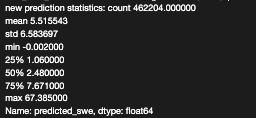



---





---




# Results

This is the whole process of how the predictions are converted into Images.

**Convert result to image:**

**convert csvs to images simple:** This Is the function that takes the raw data and converts them into Geographical images.

**Data Loading:** Begins by ingesting the CSV containing SWE predictions, ensuring every data point is primed for visualization. Custom Colormap Creation: Employs a custom colormap, meticulously crafted to represent various ranges of SWE, providing an intuitive visual understanding of snow coverage. Geospatial Plotting: Utilizes the geographical coordinates within the data to accurately place each prediction on the map, ensuring a realistic representation of SWE distribution.

**Merge data:** The merge_data function plays a crucial role in combining the predicted SWE values with their corresponding geographical markers. Conditional Adjustments: Refines the predicted values based on specific criteria, ensuring the visual representation aligns with realistic expectations of SWE.

**Spatial Accuracy:** Aligns predictions with their exact geographical locations, ensuring that the visual output is as informative as it is accurate.

**Custom Colormap:** A list named colors defines the color scheme for the colormap, using RGB tuples for each color.These colors are intended to represent different levels of SWE, from low to high(light gray to dark red).

**Geographical Boundaries:** lon_min, lon_max, lat_min, and lat_max define the geographical area of interest by specifying the minimum and maximum longitudes and latitudes. This setting targets the visualization and analysis efforts to the Western United States.

In [ ]:
colors = [
    (0.8627, 0.8627, 0.8627),  # #DCDCDC - 0 - 1
    (0.8627, 1.0000, 1.0000),  # #DCFFFF - 1 - 2
    (0.6000, 1.0000, 1.0000),  # #99FFFF - 2 - 4
    (0.5569, 0.8235, 1.0000),  # #8ED2FF - 4 - 6
    (0.4509, 0.6196, 0.8745),  # #739EDF - 6 - 8
    (0.4157, 0.4706, 1.0000),  # #6A78FF - 8 - 10
    (0.4235, 0.2784, 1.0000),  # #6C47FF - 10 - 12
    (0.5529, 0.0980, 1.0000),  # #8D19FF - 12 - 14
    (0.7333, 0.0000, 0.9176),  # #BB00EA - 14 - 16
    (0.8392, 0.0000, 0.7490),  # #D600BF - 16 - 18
    (0.7569, 0.0039, 0.4549),  # #C10074 - 18 - 20
    (0.6784, 0.0000, 0.1961),  # #AD0032 - 20 - 30
    (0.5020, 0.0000, 0.0000)   # #800000 - > 30
]
cmap_name = 'custom_snow_colormap'
custom_cmap = mcolors.ListedColormap(colors)

lon_min, lon_max = -125, -100
lat_min, lat_max = 25, 49.5

# Define value ranges for color mapping
fixed_value_ranges = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 30]


**Convert csv to geotiff:** This function mainly helps in converting images to geographically accurate maps.

**Rasterization:** Transforms the CSV data into a raster format, suitable for creating detailed geospatial maps.

**Resolution and Coverage:** Carefully defines the resolution and geographical extent of the output map, ensuring that it captures the full scope of the predictions.

**Geospatial Alignment:** Utilizes rasterio and geopandas libraries to ensure that each pixel in the output map accurately represents the predicted SWE values at specific geographical coordinates.

**Deploy images to website:**
This is the process that helps in Deploying the visual insights

**copy files to right folder** --

Function: Bridging Computational Outputs with Public Access At the heart of our deployment strategy lies the copy_files_to_right_folder function.
This function acts as the bridge, transferring the visual and data outputs of SnowCast from the secure confines of its computational environment to a publicly accessible web directory.

Here's how it achieves this pivotal role:


*   Folder Synchronization: Utilizing distutils.dir_util.copy_tree, it ensures that all visual comparisons and predictions are mirrored from the SnowCast workspace to the web server's plotting directory, maintaining up-to-date access for users worldwide.
*   Selective Deployment: Through meticulous directory traversal, it distinguishes between .png visualizations and .tif geospatial files, ensuring each file type is deployed to its rightful place for optimal public utility.












**create mapserver map config: Crafts interactive Maps**

The magic of SnowCast is not just in its predictions but in how these predictions are presented. The create_mapserver_map_config function crafts a MapServer configuration for each GeoTIFF prediction file, transforming static data into interactive, exploratory maps.


*   **Dynamic Configuration:** By generating a .map file for each prediction, this function lays the groundwork for interactive map services, allowing users to explore SWE predictions across different regions and times.
*   **Intuitive Visualization:** The custom MapServer configuration leverages the power of geographical information systems (GIS) to provide an intuitive, visual representation of complex SWE data, making it accessible to experts and laypeople alike.








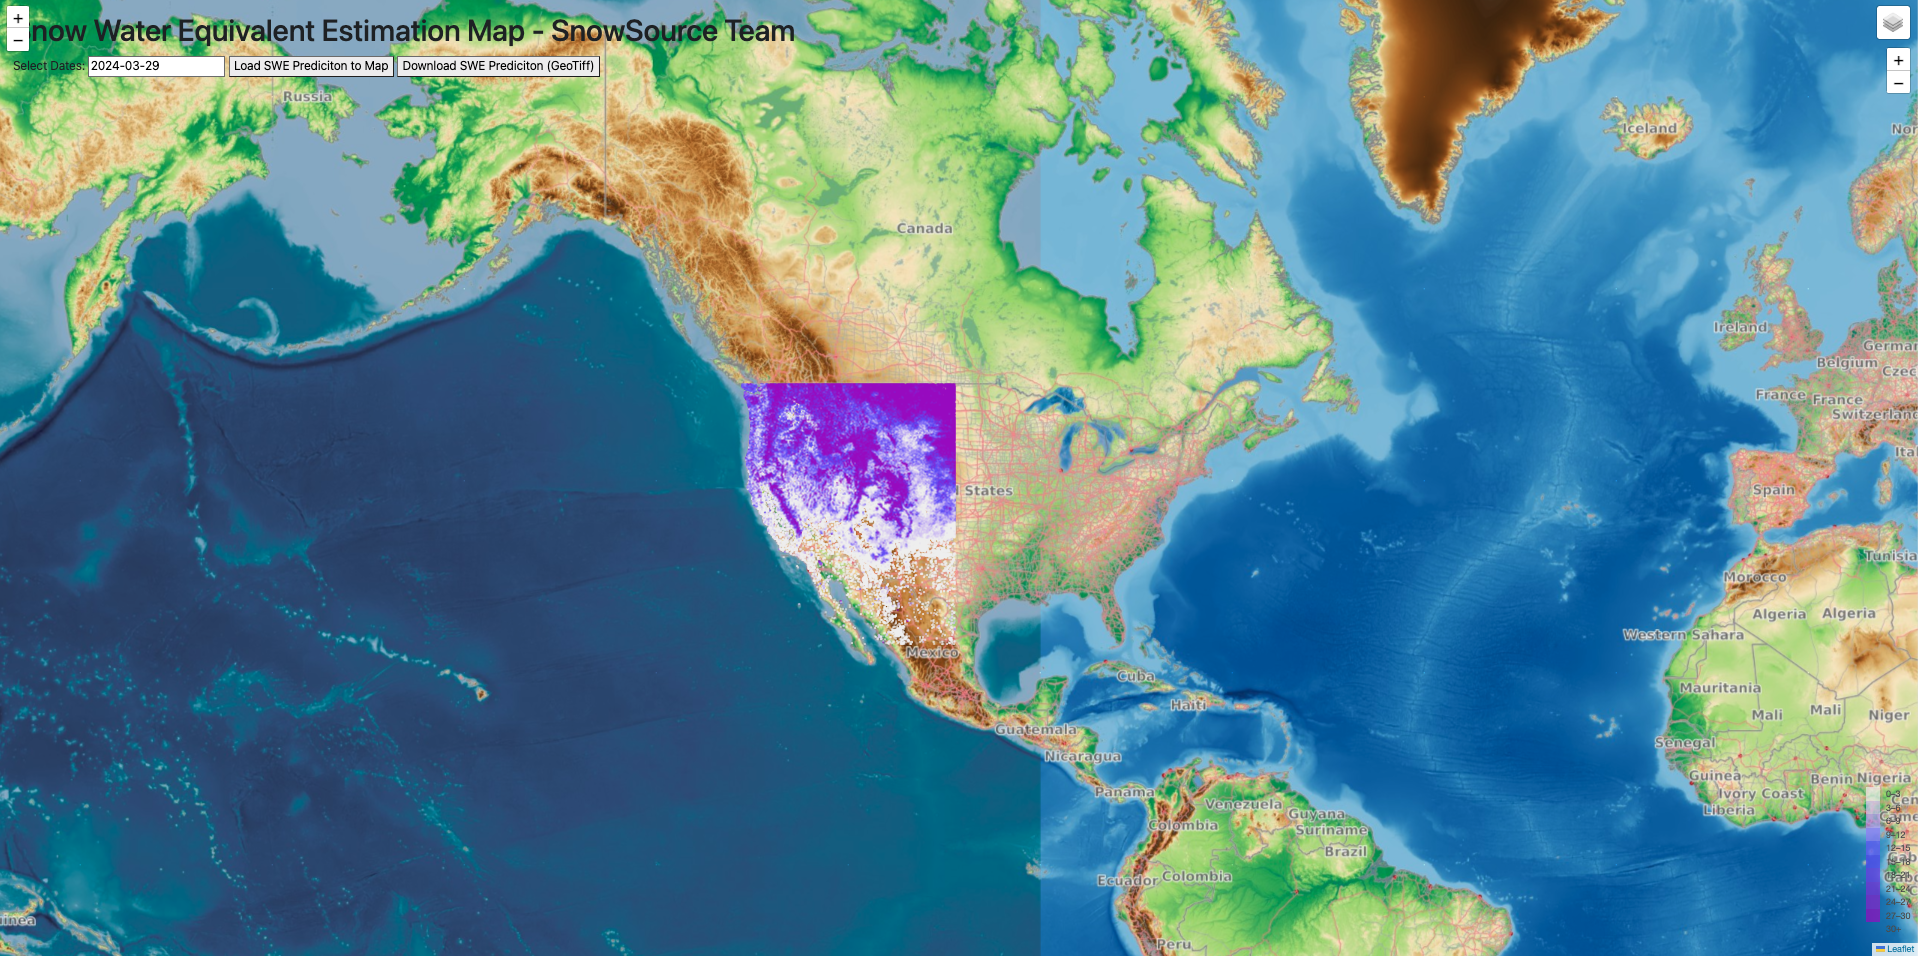

**refresh available date list: Refreshing the Forecast**

The refresh_available_date_list function ensures that the SnowCast portal remains current, reflecting the latest predictions and analyses. By dynamically updating the available date list with new predictions, it guarantees that users have access to the most recent insights.


*   Data Frame Dynamics: This function creates a pandas DataFrame to catalog the available predictions, linking each date with its corresponding visualization and data file, thereby ensuring the portal's content is both comprehensive and current.
*   Seamless Integration: The updated date list is saved as a CSV file, seamlessly integrating with the web portal's infrastructure to refresh the interactive calendar, guiding users to the latest SWE predictions.






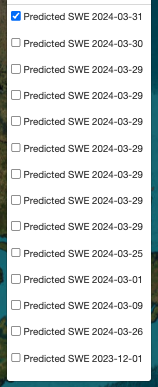